[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lisuex/Machine-Learning2025/blob/main/Lab10.ipynb)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2048, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# MLP Model Definition
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28*28, 1024)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(1024, 2048)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(2048, 256)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.linear1(x))
        x = self.relu2(self.linear2(x))
        x = self.relu3(self.linear3(x))
        x = self.linear4(x)
        return x

# LeNet-5 CNN Model
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Train Function
def train_model(model, name="Model"):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(8):
        model.train()
        for inputs, labels in tqdm(trainloader, desc=f"{name} - Epoch {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(inputs), labels)
            loss.backward()
            optimizer.step()
    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"{name} Accuracy: {100 * correct / total:.2f}%")
    return model

# Train Both Models
mlp_model = train_model(MLP(), "MLP")
cnn_model = train_model(LeNet5(), "LeNet-5")

MLP - Epoch 8: 100%|██████████| 30/30 [00:32<00:00,  1.07s/it]


MLP Accuracy: 98.15%


LeNet-5 - Epoch 8: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


LeNet-5 Accuracy: 96.90%



MLP dreams (L2=0.0)


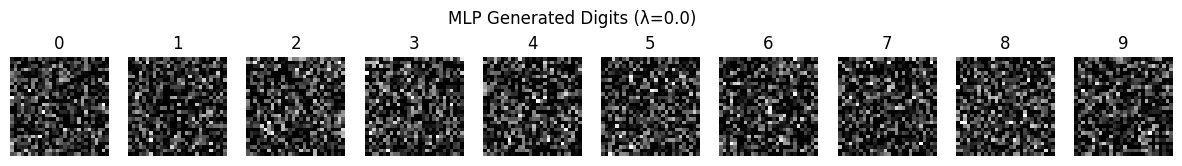


LeNet-5 dreams (L2=0.0)


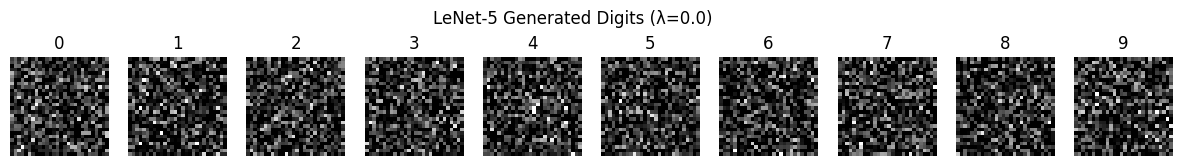


MLP dreams (L2=0.01)


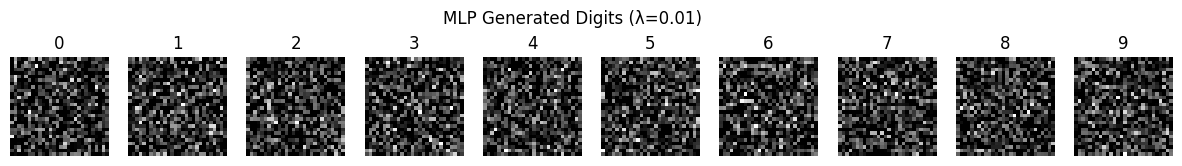


LeNet-5 dreams (L2=0.01)


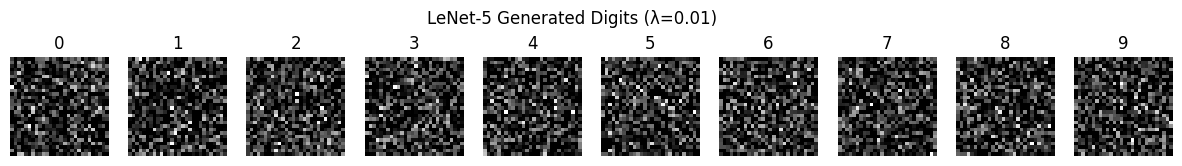


MLP dreams (L2=0.1)


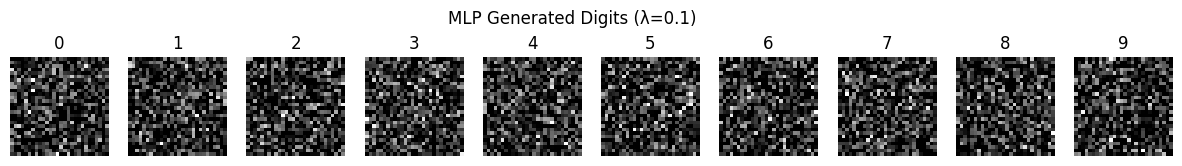


LeNet-5 dreams (L2=0.1)


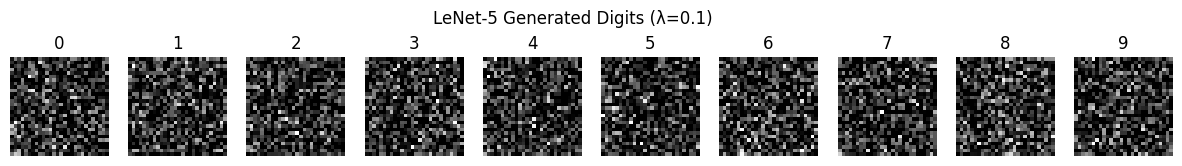


MLP dreams (L2=1.0)


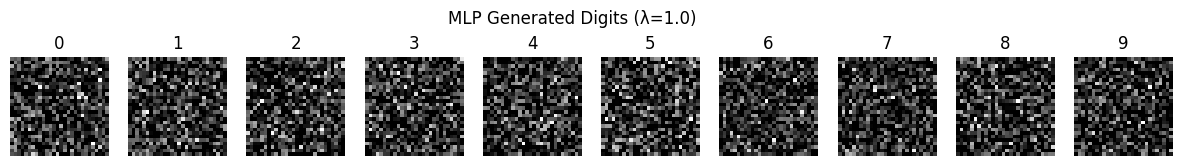


LeNet-5 dreams (L2=1.0)


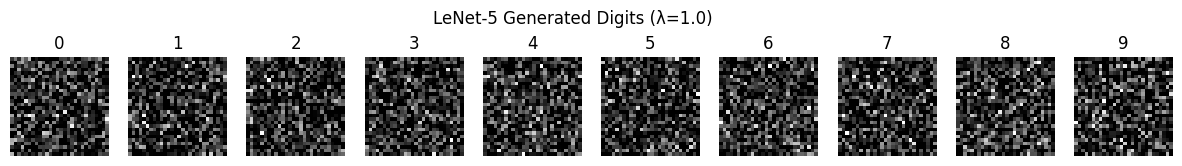


MLP dreams (L2=5.0)


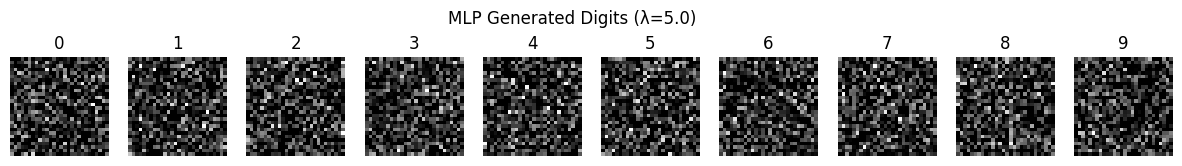


LeNet-5 dreams (L2=5.0)


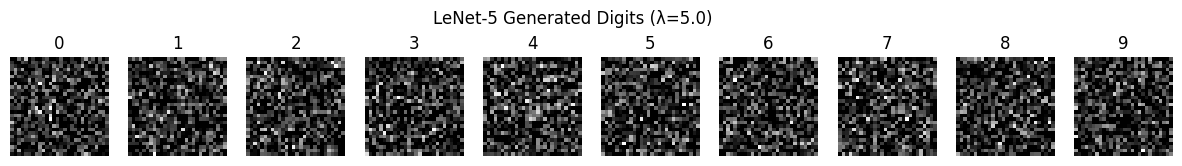


MLP dreams (L2=10.0)


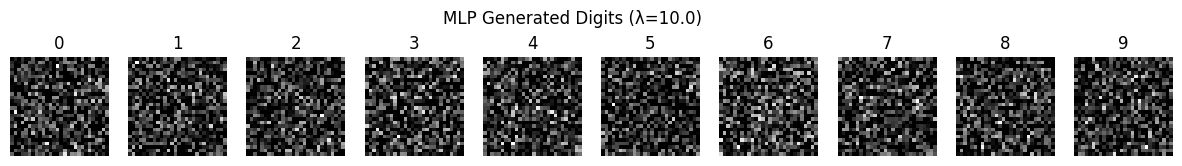


LeNet-5 dreams (L2=10.0)


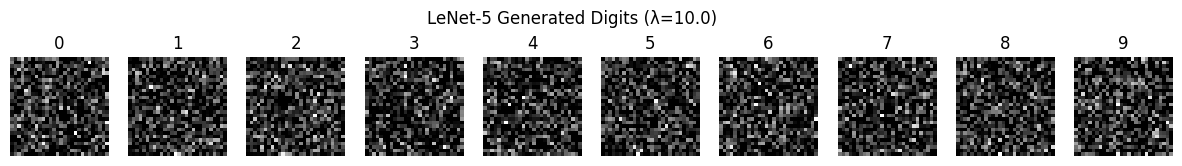

In [13]:
# Task 1: Generate and Compare Dreams

# Dream Generation Function
def generate_dreams(model, model_name="MLP", lambda_l2=0.0, num_iter=300):
    num_digits = 10
    images = torch.randn((num_digits, 1, 28, 28), device=device, requires_grad=True)
    targets = torch.arange(num_digits, device=device)
    inverse_normalize = transforms.Normalize(mean=[-0.1307/0.3081], std=[1/0.3081])
    optimizer = torch.optim.SGD([images], lr=0.1)

    for iteration in range(num_iter):
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, targets)
        loss += lambda_l2 * images.pow(2).mean()
        loss.backward()
        optimizer.step()

    # Visualization
    images_clamped = torch.clamp(inverse_normalize(images.detach().cpu()), 0, 1)
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axes[i].imshow(images_clamped[i][0], cmap='gray')
        axes[i].set_title(f"{i}")
        axes[i].axis('off')
    plt.suptitle(f"{model_name} Generated Digits (λ={lambda_l2})")
    plt.show()
    return images_clamped

for l2 in [0.0, 0.01, 0.1, 1.0, 5.0, 10.0]:
    print(f"\nMLP dreams (L2={l2})")
    generate_dreams(mlp_model, "MLP", lambda_l2=l2)
    print(f"\nLeNet-5 dreams (L2={l2})")
    generate_dreams(cnn_model, "LeNet-5", lambda_l2=l2)

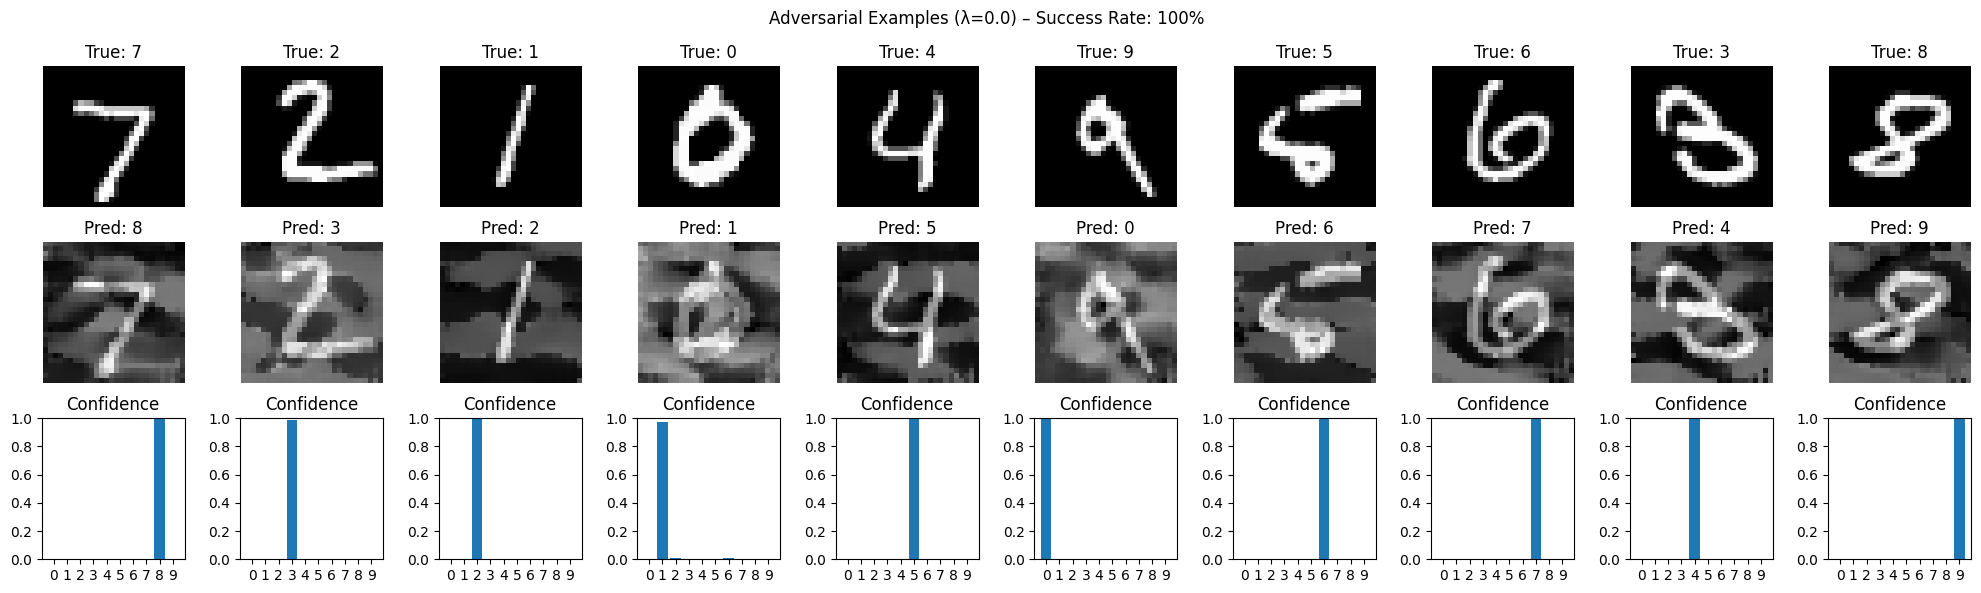

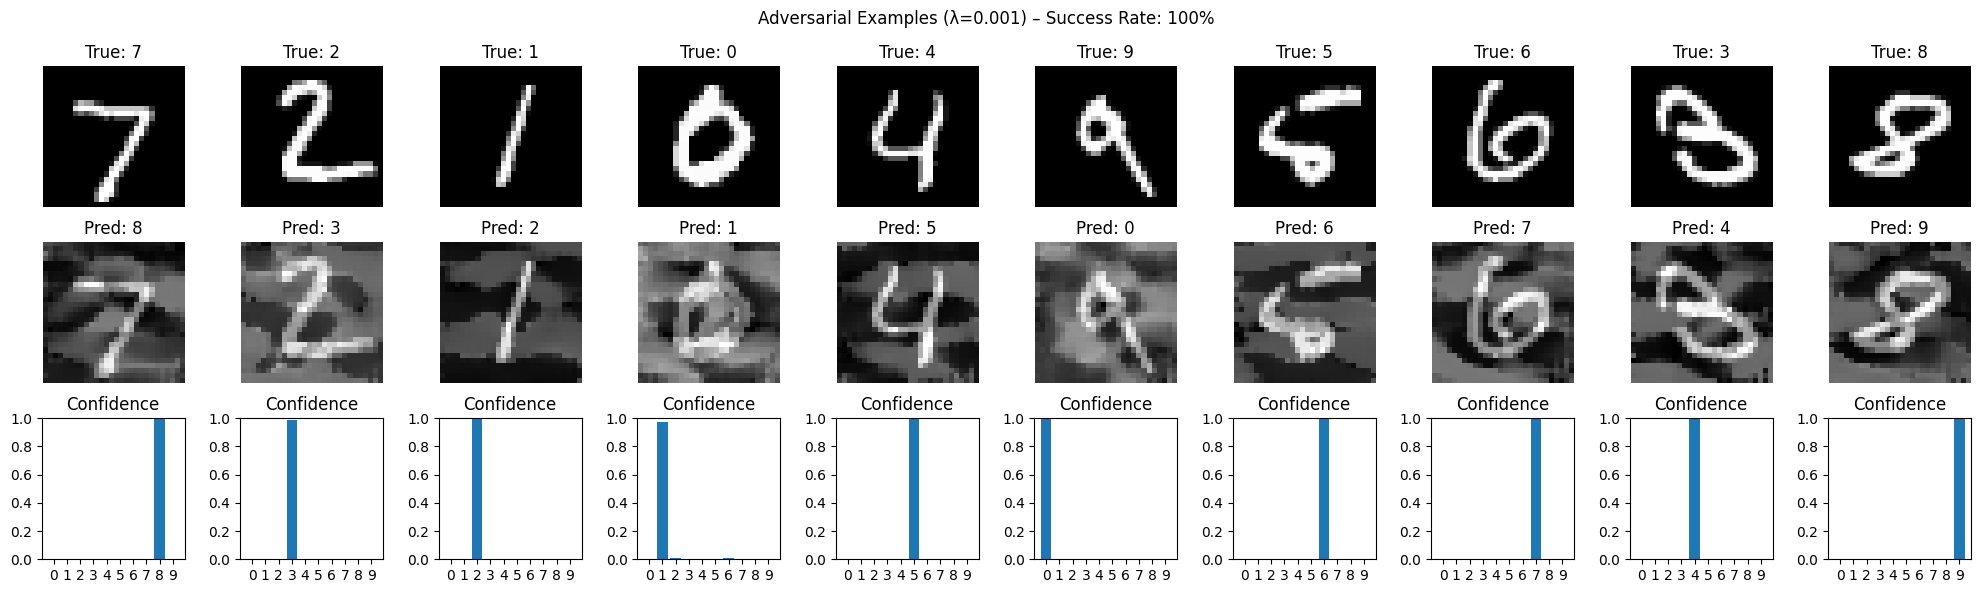

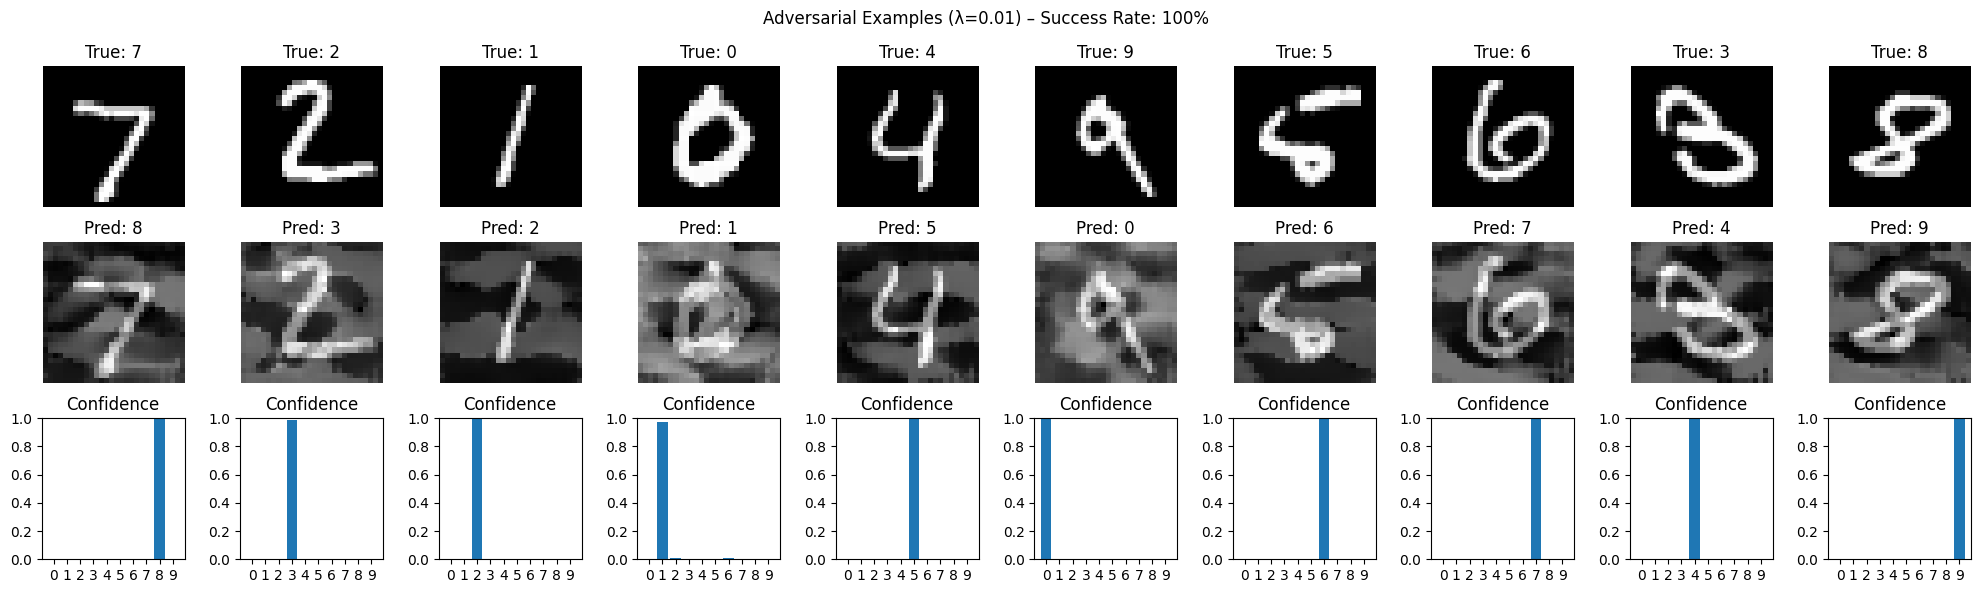

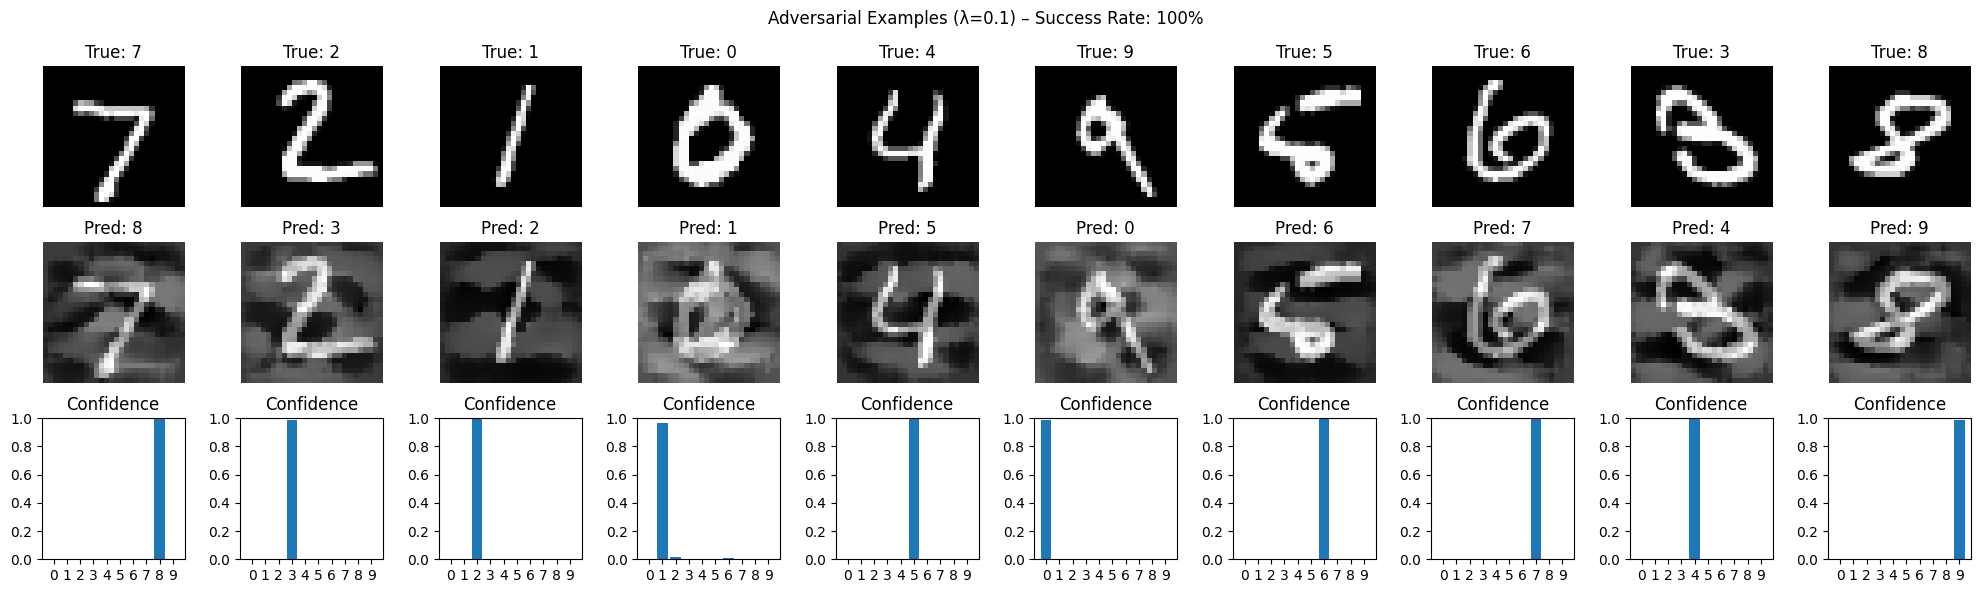

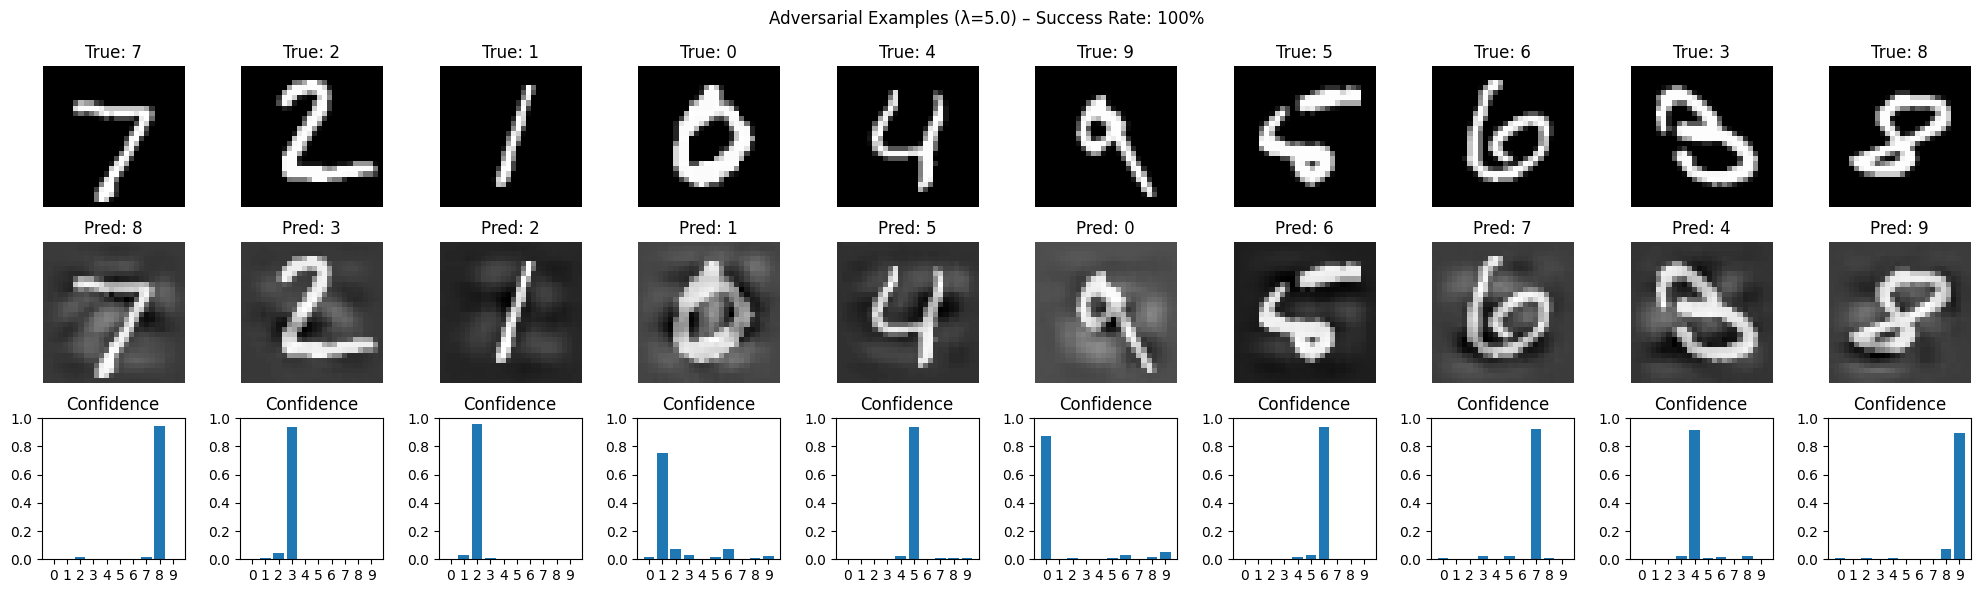

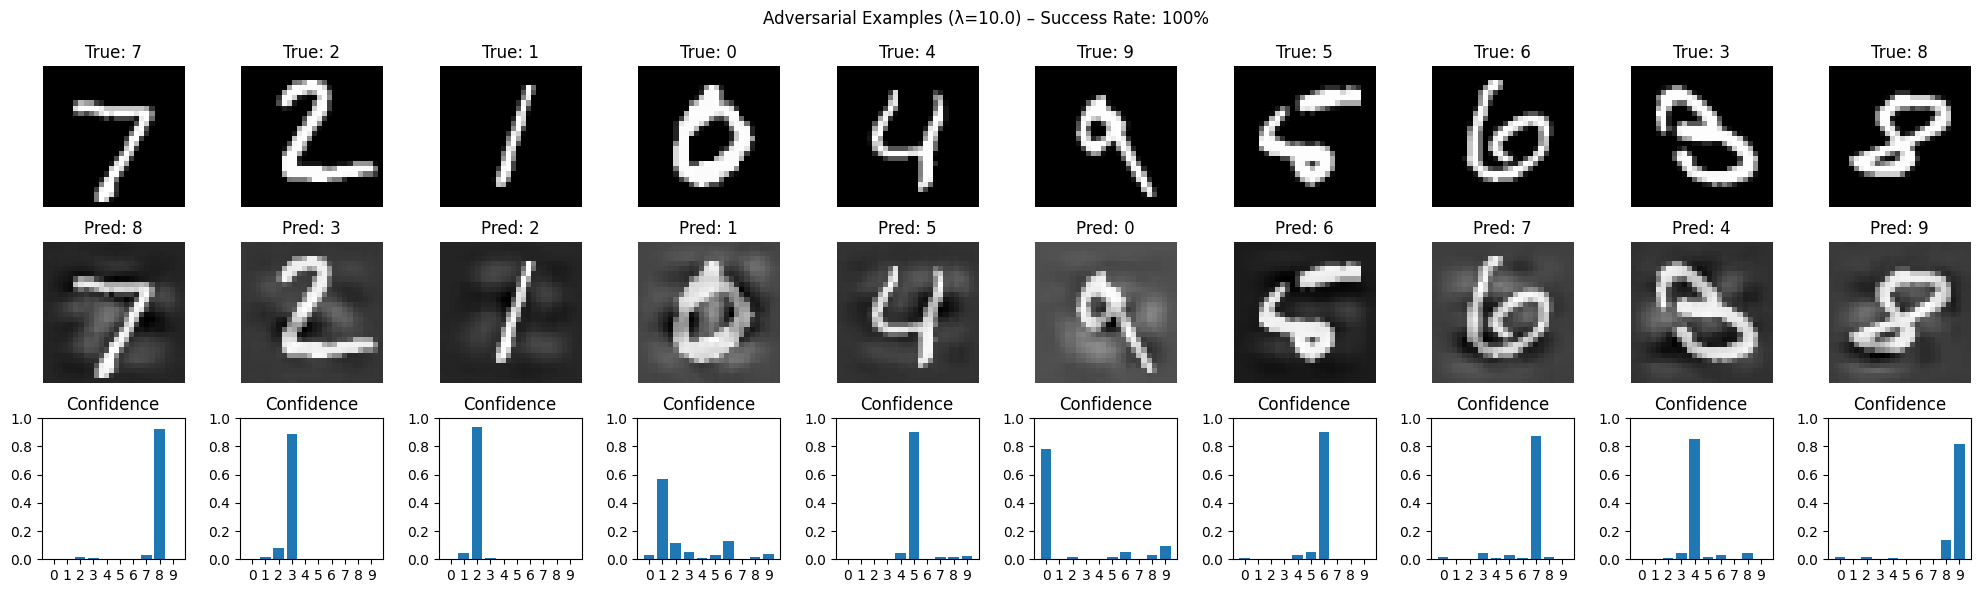

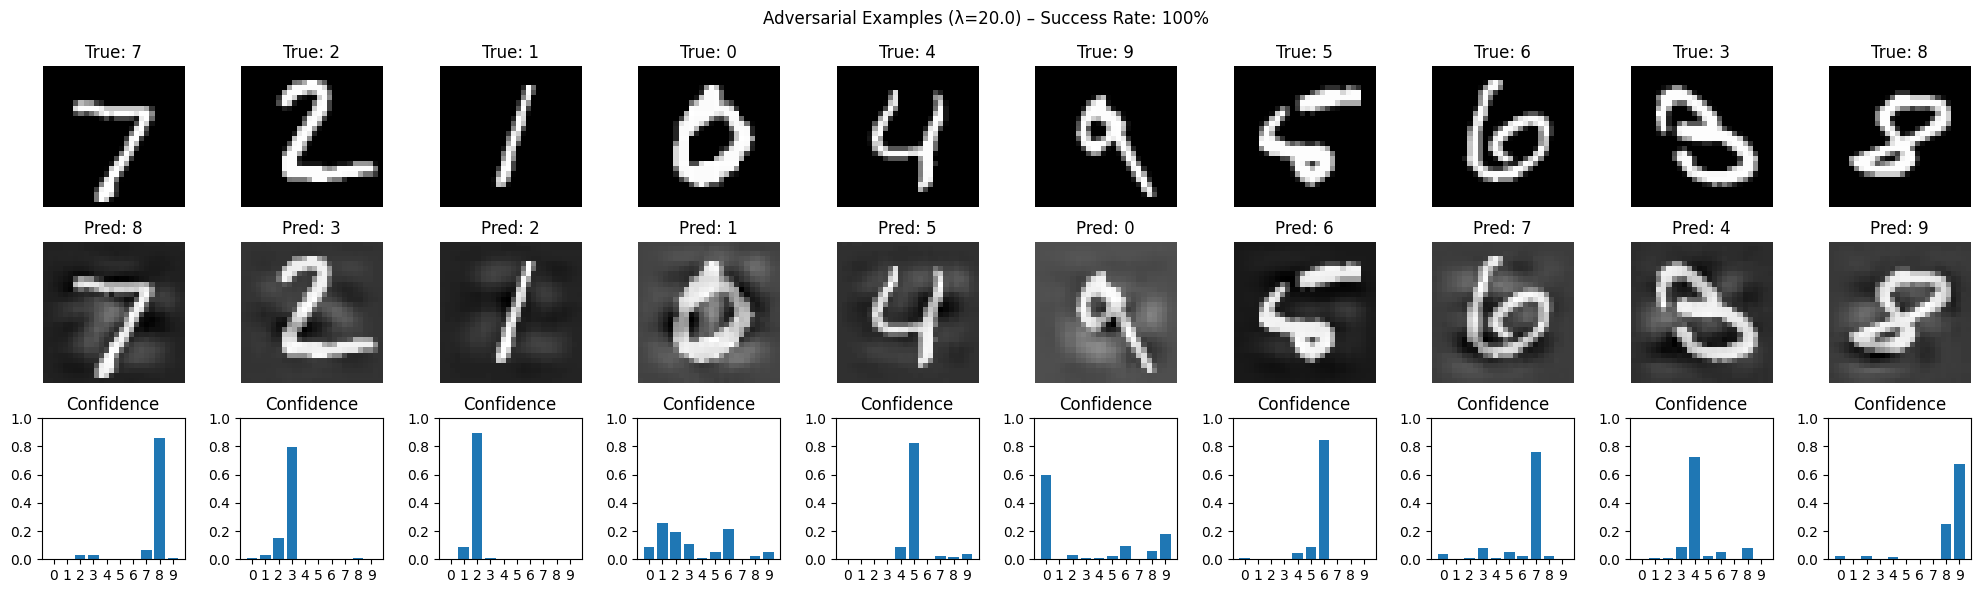

In [14]:
# Task 2: Adversarial Examples
def adversarial_example(img, label, net, target_label, lambda_l2=0.01, steps=100, lr=0.05):
    delta = torch.zeros_like(img, requires_grad=True)
    optimizer = torch.optim.Adam([delta], lr=lr)
    net.eval()
    for _ in range(steps):
        optimizer.zero_grad()
        output = net(img + delta)
        loss = F.cross_entropy(output, torch.tensor([target_label], device=img.device)) + lambda_l2 * delta.pow(2).mean()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        output = net(img + delta)
        softmax = F.softmax(output, dim=1).cpu().squeeze()
        # debug print to see what are the probabilities for other digits
        # print(f"True: {label}, Target: {target_label}, Pred: {softmax.argmax().item()}, Softmax: {softmax.numpy().round(3)}")

    return (img + delta).detach().cpu(), softmax

lambda_values = [0.0, 0.001, 0.01, 0.1, 5.0, 10.0, 20.0]
results = {}

# Run experiments for each lambda value
for lambda_l2 in lambda_values:
    examples = []
    success_count = 0
    labels_used = []

    for data in testloader:
        image, label = data
        image = image.to(device)
        if label.item() in labels_used:
            continue
        labels_used.append(label.item())
        wrong_label = (label.item() + 1) % 10
        adv_img, softmax = adversarial_example(image, label.item(), cnn_model, wrong_label, lambda_l2)
        pred = softmax.argmax().item()
        success = int(pred == wrong_label)
        success_count += success
        examples.append((image.squeeze().cpu(), adv_img.squeeze(), label.item(), pred, softmax.squeeze()))
        if len(examples) == 10:
            break

    results[lambda_l2] = {
        'examples': examples,
        'success_rate': success_count / 10
    }

# Visualize examples for each lambda
for lambda_l2 in lambda_values:
    examples = results[lambda_l2]['examples']
    fig, axs = plt.subplots(3, 10, figsize=(20, 6))  # 3 rows now

    for i, (orig, adv, lbl, pred, softmax) in enumerate(examples):
        axs[0, i].imshow(orig, cmap='gray')
        axs[0, i].set_title(f"True: {lbl}")
        axs[0, i].axis('off')

        axs[1, i].imshow(adv, cmap='gray')
        axs[1, i].set_title(f"Pred: {pred}")
        axs[1, i].axis('off')

        # Plot confidence levels
        axs[2, i].bar(range(10), softmax.numpy())
        axs[2, i].set_ylim([0, 1])
        axs[2, i].set_xticks(range(10))
        axs[2, i].set_title("Confidence")

    plt.suptitle(f"Adversarial Examples (λ={lambda_l2}) – Success Rate: {results[lambda_l2]['success_rate']*100:.0f}%")
    plt.tight_layout()
    plt.show()


# Questions

## Task1

**• Are the generated images more or less readable than those from the MLP?**  
In my opinion, the digits from both models are not readable. I generated them in the same way as in Lab09, and the result looks similarly unclear.

**• Do they resemble real MNIST digits more closely or less?**  
They don’t resemble real digits well. Just like in Lab09, they look very rough and unrealistic.

**• Why do you think that happens?**  
CNNs are good at recognizing real patterns, but they’re not easy to trick into generating digits from random noise.  
MLPs don’t have those built-in rules, so they can follow the gradient more freely.  
However, since neither model uses any realistic prior or strong regularization, both struggle to generate believable digits from pure noise.

## Task2

**• Success rate of attacks:**  
All of the attacks were successful. For the 10 tested digits, the network misclassified all of the adversarial examples into the targeted wrong class.

**• Effect of $\lambda_{l2}$:**  
- When $\lambda_{l2}$ is small, the attack is more successful, but the noise becomes more visible.  
- When $\lambda_{l2}$ is larger, the noise is less noticeable, but the success rate of misclassification drops.  
- A balance is needed to make the noise both hard to notice and effective.

**• Image grid and confidence plots:**  
Images show the change from the original to the adversarial version.  
Even though they look similar, the predictions change completely, showing how sensitive the network is to small perturbations.
Confidence plots show that for small lambdas the misclassification is almost perfect (almost 100% probability for misclassification), but when the lambda gets bigger, the probability drops.
